# Green Prism — Transparency Score (NLP Model v1)

Goal: Implement and validate an NLP-based Transparency Score model.

Pipeline:

1. Text cleaning (strip boilerplate).
2. Tokenization + encoding via FinBERT / BERT.
3. Get [CLS] embedding as a dense representation.
4. Concatenate handcrafted pattern-based features.
5. Train GradientBoostingRegressor to predict transparency score (0–100),
   using the existing rule-based model as a teacher (pseudo-labels).


## 0. Imports & Path Setup

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

import torch
from transformers import AutoTokenizer, AutoModel

# Adjust path to reach backend package
NOTEBOOK_DIR = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_DIR.parents[3]
BACKEND_ROOT = REPO_ROOT / "backend"

sys.path.insert(0, str(BACKEND_ROOT))

from app.ml.transparency_model import score_transparency
from app.ml.preprocessing import clean_text


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Bonds Dataset

In [2]:
# Adjust this path if bonds.csv lives somewhere else
DATA_PATH = BACKEND_ROOT / "app" / "data" / "bonds.csv"
print("DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Loaded bonds.csv:", df.shape)
df.head()


DATA_PATH: /Users/radhamunver/Downloads/GreenPrism/green-prism/backend/app/data/bonds.csv
Loaded bonds.csv: (4965, 19)


,bond_id,source_dataset,isin,issuer_name,issuer_type,country,currency,amount_issued,amount_issued_usd,issue_date,issue_year,maturity_date,maturity_year,use_of_proceeds,external_review_type,certification,claimed_impact_co2_tons,actual_impact_co2_tons,impact_source
0,WB-XS2913418377,NaN,XS2913418377,IBRD,Multilateral Dev Bank,World,BRL,6.000000e+07,11290929.62,2025-09-23,2025.0,2031-10-09,2031.0,Green,NaN,World Bank Green Bond,NaN,NaN,NaN
1,WB-US45906M4W82,NaN,US45906M4W82,IBRD,Multilateral Dev Bank,World,USD,3.000000e+07,30000000.00,2024-02-16,2024.0,2029-02-16,2029.0,Green,NaN,World Bank Green Bond,NaN,NaN,NaN
2,WB-XS2439224705,NaN,XS2439224705,IBRD,Multilateral Dev Bank,World,BRL,2.000000e+08,40650406.50,2024-02-01,2024.0,2029-02-09,2029.0,Green,NaN,World Bank Green Bond,NaN,NaN,NaN
3,WB-XS2437747210,NaN,XS2437747210,IBRD,Multilateral Dev Bank,World,CNH,2.000000e+08,27892057.74,2024-01-30,2024.0,2029-01-19,2029.0,Green,NaN,World Bank Green Bond,NaN,NaN,NaN
4,WB-XS2749786195,NaN,XS2749786195,IBRD,Multilateral Dev Bank,World,INR,4.500000e+09,54171180.93,2024-01-25,2024.0,2031-01-25,2031.0,Green,NaN,World Bank Green Bond,NaN,NaN,NaN


### 1.1 Construct a Disclosure Text Field

In [3]:
TEXT_COLUMN = None

# If there's already a rich text column, use it
for candidate in ["disclosure_text", "framework_text", "impact_report_text"]:
    if candidate in df.columns:
        TEXT_COLUMN = candidate
        break

if TEXT_COLUMN is None:
    # Build a proxy text field
    def make_proxy_text(row):
        parts = []
        for col in ["issuer_name", "issuer_type", "country", "use_of_proceeds", "certification", "external_review_type"]:
            if col in row and pd.notna(row[col]):
                parts.append(f"{col.replace('_', ' ')}: {row[col]}")
        return " | ".join(parts)

    df["proxy_disclosure_text"] = df.apply(make_proxy_text, axis=1)
    TEXT_COLUMN = "proxy_disclosure_text"

print("Using text column:", TEXT_COLUMN)
df[[TEXT_COLUMN]].head()


Using text column: proxy_disclosure_text


,proxy_disclosure_text
0,issuer name: IBRD | issuer type: Multilateral ...
1,issuer name: IBRD | issuer type: Multilateral ...
2,issuer name: IBRD | issuer type: Multilateral ...
3,issuer name: IBRD | issuer type: Multilateral ...
4,issuer name: IBRD | issuer type: Multilateral ...


## 2. Text Cleaning

In [4]:
df["clean_text"] = df[TEXT_COLUMN].fillna("").astype(str).apply(clean_text)
df[["clean_text"]].head()

,clean_text
0,issuer name: IBRD | issuer type: Multilateral ...
1,issuer name: IBRD | issuer type: Multilateral ...
2,issuer name: IBRD | issuer type: Multilateral ...
3,issuer name: IBRD | issuer type: Multilateral ...
4,issuer name: IBRD | issuer type: Multilateral ...


## 3. Handcrafted Pattern-Based Features

In [5]:
import re

PATTERNS = {
    "has_third_party_review": [
        r"second[- ]party opinion",
        r"external review",
        r"third[- ]party verification",
        r"assurance",
        r"spo by",
        r"sustainalytics",
        r"cicero",
        r"vigeo",
    ],
    "has_reporting_annual": [
        r"annual report",
        r"annual reporting",
    ],
    "has_reporting_semi_annual": [
        r"semi[- ]annual",
        r"semiannual",
    ],
    "has_kpi_co2": [
        r"\bco2\b",
        r"carbon emissions",
        r"greenhouse gas",
        r"\bghg\b",
    ],
    "has_kpi_energy": [
        r"mwh",
        r"kwh",
        r"kw\b",
        r"energy efficiency",
        r"renewable energy",
    ],
}


def handcrafted_features(text: str) -> np.ndarray:
    t = text.lower()
    feats = []

    for name, patterns in PATTERNS.items():
        flag = any(re.search(p, t) for p in patterns)
        feats.append(1.0 if flag else 0.0)

    # numeric intensity: count numbers (could be baselines/targets)
    num_numbers = len(re.findall(r"\d+(?:\.\d+)?", t))
    feats.append(float(num_numbers))

    return np.array(feats, dtype=np.float32)


handcrafted_dim = len(PATTERNS) + 1
print("Handcrafted feature dimension:", handcrafted_dim)


Handcrafted feature dimension: 6


## 4. Load FinBERT / BERT Model

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "ProsusAI/finbert"  # fall back to 'bert-base-uncased' if this fails

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()

print("Loaded model:", MODEL_NAME, "on", DEVICE)

Loaded model: ProsusAI/finbert on cpu


### 4.1 Embedding Function

In [7]:
from typing import List

@torch.no_grad()
def embed_texts(texts: List[str], batch_size: int = 8) -> np.ndarray:
    all_embs = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt",
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}

        outputs = model(**enc)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embs.append(cls_emb.cpu().numpy())

    return np.vstack(all_embs)


## 5. Build Training Dataset (Teacher = Rule-Based Model)

In [8]:
# Sample subset for speed
N = 1000
df_sample = df.sample(min(N, len(df)), random_state=42).reset_index(drop=True)
print("Sampled rows:", df_sample.shape)

# Teacher labels
teacher_scores = df_sample["clean_text"].apply(lambda t: score_transparency(t).overall)
df_sample["teacher_transparency_score"] = teacher_scores
df_sample[["clean_text", "teacher_transparency_score"]].head()


Sampled rows: (1000, 21)


,clean_text,teacher_transparency_score
0,issuer name: EDENRED | issuer type: Corporate ...,48.0
1,"issuer name: Korea, Rep. of | issuer type: Not...",30.0
2,"issuer name: China, P.R.: Hong Kong | issuer t...",30.0
3,issuer name: QUEENSLAND TREASURY CORPORATION |...,50.4
4,"issuer name: Netherlands, The | issuer type: N...",30.0


In [9]:
import inspect
import app.ml.transparency_model as tm

print("Using module file:", tm.__file__)
print("---- score_transparency source ----")
print(inspect.getsource(tm.score_transparency))


Using module file: /Users/radhamunver/Downloads/GreenPrism/green-prism/backend/app/ml/transparency_model.py
---- score_transparency source ----
def score_transparency(
    text: str, *, precomputed_features: Optional[TextFeatures] = None
) -> TransparencyComponents:
    feats = precomputed_features or extract_text_features(text)

    uop = _score_use_of_proceeds(feats)
    rep = _score_reporting(feats)
    ver = _score_verification(feats)

    return TransparencyComponents(
        use_of_proceeds_clarity=round(uop, 1),
        reporting_practices=round(rep, 1),
        verification_strength=round(ver, 1),
        raw_features=feats,
    )



In [10]:
# Extract embeddings
texts = df_sample["clean_text"].tolist()
cls_embeddings = embed_texts(texts, batch_size=8)
print("CLS embeddings shape:", cls_embeddings.shape)

# Handcrafted features
handcrafted = np.stack([handcrafted_features(t) for t in texts], axis=0)
print("Handcrafted features shape:", handcrafted.shape)

# Concatenate
X = np.concatenate([cls_embeddings, handcrafted], axis=1)
y = df_sample["teacher_transparency_score"].values.astype(np.float32)

X.shape, y.shape


CLS embeddings shape: (1000, 768)
Handcrafted features shape: (1000, 6)


((1000, 774), (1000,))

## 6. Train GradientBoostingRegressor

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation R^2:   {r2:.3f}")


Validation RMSE: 0.550
Validation R^2:   0.997


### 6.1 Diagnostic Plot (Optional)

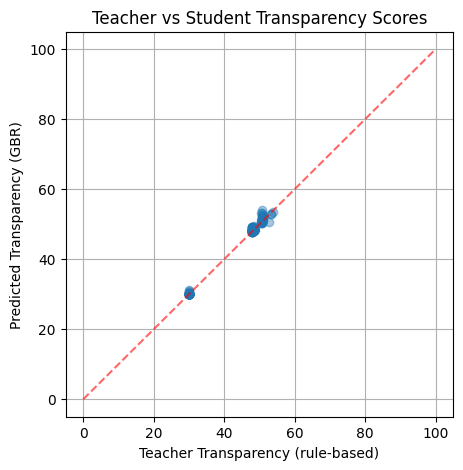

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_val, y_pred, alpha=0.4)
plt.xlabel("Teacher Transparency (rule-based)")
plt.ylabel("Predicted Transparency (GBR)")
plt.title("Teacher vs Student Transparency Scores")
plt.plot([0, 100], [0, 100], "r--", alpha=0.6)
plt.grid(True)
plt.show()


## 7. Save Model Artifact

In [13]:
from joblib import dump

MODEL_DIR = BACKEND_ROOT / "app" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "transparency_regressor_gbr.joblib"

def clamp_0_100(val: np.ndarray) -> np.ndarray:
    return np.clip(val, 0.0, 100.0)

y_pred_clamped = clamp_0_100(y_pred)
print("Sample clamped predictions:", y_pred_clamped[:5])

artifact = {
    "model": gbr,
    "feature_dim": X.shape[1],
    "handcrafted_dim": handcrafted_dim,
    "base_nlp_model_name": MODEL_NAME,
}

dump(artifact, MODEL_PATH)
print("Saved model to:", MODEL_PATH)


Sample clamped predictions: [30.01895681 53.1220636  30.00630131 30.1572723  48.058961  ]
Saved model to: /Users/radhamunver/Downloads/GreenPrism/green-prism/backend/app/models/transparency_regressor_gbr.joblib


## 8. Example Inference Function

In [14]:
from joblib import load

def load_trained_model(model_path: Path = MODEL_PATH):
    artifact = load(model_path)
    return artifact

def predict_transparency_score_ml(text: str, artifact: dict) -> float:
    cleaned = clean_text(text)
    emb = embed_texts([cleaned])  # (1, hidden)
    hand = np.stack([handcrafted_features(cleaned)], axis=0)  # (1, H)
    feats = np.concatenate([emb, hand], axis=1)  # (1, D)
    score = artifact["model"].predict(feats)[0]
    return float(clamp_0_100(score))

artifact_loaded = load_trained_model()
example_text = df_sample["clean_text"].iloc[0]
print("Example text:", example_text[:200], "...")
print("ML transparency score:", predict_transparency_score_ml(example_text, artifact_loaded))
print("Teacher score:", df_sample["teacher_transparency_score"].iloc[0])


Example text: issuer name: EDENRED | issuer type: Corporate - Consumer Discretionary | country: France | use of proceeds: Sustainability Linked Bonds | certification: Sustainability Linked Bonds | external review t ...
ML transparency score: 48.06631435848348
Teacher score: 48.0


---
## Next Steps

- Replace teacher labels with human labels for a subset of bonds.
- Extend to multi-output regression to predict:
  - use_of_proceeds_clarity
  - reporting_practices
  - verification_strength
- Move the inference function into a dedicated module
  (e.g., `app/ml/transparency_model_ml.py`).
- Add a switch in the FastAPI service to choose between rule-based
  and ML-based transparency scoring.
